## 导包

In [1]:
import torch
import torch.nn as nn
from collections import OrderedDict
import numpy as np
# %matplotlib widget
from matplotlib import pyplot as plt
from numpy import matrix as mat
from torch.nn.modules import loss
from functorch import make_functional, vmap, grad, jacrev, hessian
import jax
import time
from matplotlib.ticker import FuncFormatter
pi=np.pi

## 模型

In [2]:
class Network(nn.Module):
    def __init__(
        self,
        input_size, # 输入层神经元数
        hidden_size, # 隐藏层神经元数
        output_size, # 输出层神经元数
        depth, # 隐藏层数
        act=torch.nn.Tanh(), # 输入层和隐藏层的激活函数
    ):
        super(Network, self).__init__()

        # 输入层
        self.layer1 = nn.Linear(in_features=input_size, out_features=hidden_size)
        #self.relu = nn.ReLU() torch.nn.Tanh()
        self.tanh = act
        # 隐藏层
        self.layer2 = nn.Linear(in_features=hidden_size, out_features=hidden_size)
        self.layer3 = nn.Linear(in_features=hidden_size, out_features=hidden_size)
        #self.relu = nn.ReLU()
        self.tanh = act
        # 输出层
        self.layer4 = nn.Linear(in_features=hidden_size, out_features=output_size,bias=False)



    def forward(self, x):
        x = self.layer1(x)
        #x = self.relu(x)
        x= self.tanh(x)
        x = self.layer2(x)
        #x = self.relu(x)
        x = self.tanh(x)
        x = self.layer3(x)
        x = self.tanh(x)
        x = self.layer4(x)

        return x
    

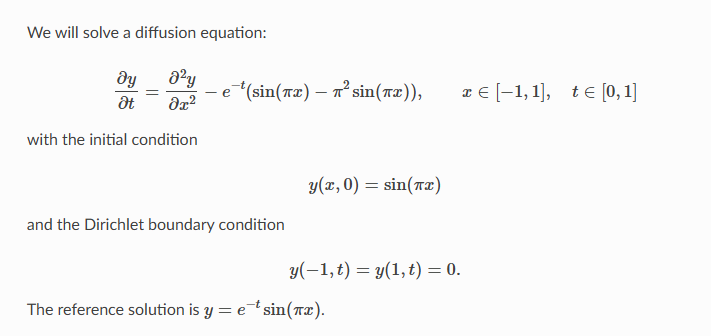

In [3]:
"""PINN_S"""
class PINN_S:
    def __init__(self):
        self.input_size = 2
        self.hidden_size =20
        self.output_size = 1
        self.depth = 1
        global device
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")  # 选择使用GPU还是CPU
        self.model = Network(self.input_size, self.hidden_size,  self.output_size, self.depth, act=  torch.nn.Tanh() ).double().to(device)  # 定义神经网络
        self.p_number = self.input_size * self.hidden_size + self.hidden_size + (self.hidden_size * self.hidden_size + self.hidden_size)*2 +self.hidden_size * self.output_size  # 参数的个数
        print('model # of parameters',self.p_number)
        
        ## Initial weights
        def initialize_weights(self):
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_normal_(m.weight.data)
                    if m.bias is not None:
                        m.bias.data.zero_()
                        # m.bias.data.normal_(mean=0.0, std=1.0)

        initialize_weights(self.model)


        
        
        self.loss_record=np.zeros(100000)
        self.loss_iter=0
        self.Sampledata=np.array([])
        self.time_iter=0
        self.time_record=np.zeros(100000)

        
    
    def new_sampling(self,i):
            """
            生成新的采样点
            i - random seed 
            points_num - # of points inside 
            """
            # 指定区间
            torch.set_default_dtype(torch.float64)
            lower_boundx = -1
            upper_boundx = 1
            lower_boundy=0
            upper_boundy=1
            random_samples = 7
            torch.manual_seed(1+i)
            x = (upper_boundx - lower_boundx) * torch.rand(random_samples) + lower_boundx 
            torch.manual_seed(2+i)
            y = (upper_boundy - lower_boundy) * torch.rand(random_samples) + lower_boundy  
            self.X_inside = torch.stack(torch.meshgrid(x, y)).reshape(2, -1).T  
            self.X_inside=self.X_inside.to(device)
            self.X_inside.requires_grad = True
            self.X_inside_num=self.X_inside.size(0) 
            
            random_samples = 10
            torch.manual_seed(3+i)
            x = (upper_boundx - lower_boundx) * torch.rand(random_samples) + lower_boundx 
            torch.manual_seed(4+i)
            y = (upper_boundy - lower_boundy) * torch.rand(random_samples) + lower_boundy 
            bc1 = torch.stack(torch.meshgrid(torch.tensor(lower_boundx).double(), y)).reshape(2, -1).T  # x=-1边界
            bc2 = torch.stack(torch.meshgrid(torch.tensor(upper_boundx).double(), y)).reshape(2, -1).T  # x=+1边界
            random_samples=10
            x = (upper_boundx - lower_boundx) * torch.rand(random_samples) + lower_boundx 
            bc3 = torch.stack(torch.meshgrid(x, torch.tensor(lower_boundy).double())).reshape(2, -1).T # y=0边界

            self.X_boundary = torch.cat([bc1, bc2, bc3])  # 将所有边界处的时空坐标点整合为一个张量
            self.X_boundary1=torch.cat([bc1, bc2])
            self.X_boundary2=bc3

            
            self.X_boundary_num1=self.X_boundary1.size(0)
            self.X_boundary_num2=self.X_boundary2.size(0)
            self.X_boundary_num=self.X_boundary_num1+self.X_boundary_num2
            self.X_inside_num=self.X_inside.size(0)

        
            self.X_boundary=self.X_boundary.to(device)
            self.X_boundary1=self.X_boundary1.to(device)
            self.X_boundary2=self.X_boundary2.to(device)
            self.X_inside=self.X_inside.to(device)

            self.X_boundary.requires_grad = True
            self.X_boundary1.requires_grad = True
            self.X_boundary2.requires_grad = True

            self.X_boundary=self.X_boundary.double()
            self.X_boundary1=self.X_boundary1.double()
            self.X_boundary2=self.X_boundary2.double()
            self.X_inside=self.X_inside.double()

    
    def LM(self,opt_num, step,deterministic=True,mu=1):
        """ 
        Parameters:
        opt_num -  优化的参数数量 
        step: LM 下降的次数 
        deterministic: 是否要严格下降 True 为是
        mu: 1 为LM method， 0 为Gauss-Newton => deterministic=False
        需要修改的部分：fx_fun 函数; J_func 函数; 
        """

        if mu==0:
            deterministic=False
        p_number = self.p_number
        params = torch.cat([p.view(-1) for p in self.model.parameters()], dim=0).to(device) # 把模型参数展平成一维向量

        
    
        def f(params, input_data):
            
            with torch.no_grad():
                a = self.hidden_size * self.input_size
                self.model.layer1.weight.data = params[:a].reshape(self.hidden_size, self.input_size).clone()  # layer1的权重
                self.model.layer1.bias.data = params[a:a + self.hidden_size].clone()  # layer1的偏置
                a += self.hidden_size
                self.model.layer2.weight.data = params[a:a + self.hidden_size * self.hidden_size].reshape(self.hidden_size, self.hidden_size).clone()  # layer2的权重
                a += self.hidden_size * self.hidden_size
                self.model.layer2.bias.data = params[a:a + self.hidden_size].clone()  # layer2的偏置
                a += self.hidden_size
                self.model.layer3.weight.data = params[a:a + self.hidden_size * self.hidden_size].reshape(self.hidden_size, self.hidden_size).clone()  # layer2的权重
                a += self.hidden_size * self.hidden_size
                self.model.layer3.bias.data = params[a:a + self.hidden_size].clone()  # layer2的偏置
                a += self.hidden_size
                self.model.layer4.weight.data = params[a:a + self.output_size * self.hidden_size].reshape(self.output_size, self.hidden_size).clone()  # layer3的权重
                a += self.output_size * self.hidden_size
                # self.model.layer3.bias.data = params[a].clone()  # layer3的偏置
            
            model_output=torch.vmap(self.model)(input_data)    
            
            return model_output
        
        def fx_fun(params)->np.array:
            
            f_inside = f(params, self.X_inside)  # 更换模型中的参数
            f_inside.require_grad = True
            du_dX = torch.autograd.grad(
                inputs=self.X_inside,
                outputs=f_inside,
                grad_outputs=torch.ones_like(f_inside),
                retain_graph=True,
                create_graph=True
                )[0][:,0]  
            du_dY = torch.autograd.grad(
                inputs=self.X_inside,
                outputs=f_inside,
                grad_outputs=torch.ones_like(f_inside),
                retain_graph=True,
                create_graph=True
            )[0][:,1]  
            du_dxx = torch.autograd.grad(
                inputs=self.X_inside,
                outputs=du_dX,
                grad_outputs=torch.ones_like(du_dX),
                retain_graph=True,
                create_graph=True
            )[0][:, 0]
            
        
            fx = du_dY-du_dxx + torch.exp(-self.X_inside[:,1])*(torch.sin(pi*self.X_inside[:,0])-(pi**2)*torch.sin(pi*self.X_inside[:,0]))
            fx=fx.to(device)
            fx=fx.view(-1)
            
            f_bd = f(params, self.X_boundary1)
            
            fx_bd = f_bd.view(-1)
            

            fx = torch.cat((fx, fx_bd), dim=0)

            f_ini=f(params, self.X_boundary2)
            f_ini=f_ini.view(-1)
            
            fx_ini = f_ini-torch.sin(torch.pi*self.X_boundary2[:,0])
            
            fx = torch.cat((fx, fx_ini), dim=0)
            fx=fx.t()
            return fx

        def F_fun(fx)->torch.tensor:
            '''计算L2范数'''
            F_p = 0
            for i in range(self.X_inside_num+self.X_boundary_num):
                F_p += (fx[i]) ** 2 
            F_p /= (self.X_inside_num+self.X_boundary_num)
            return F_p
        

        def J_func(params)->torch.tensor:
            J = torch.zeros(self.X_inside_num+self.X_boundary_num, p_number).to(device)# 初始化雅可比矩阵
            params.requires_grad_(True)
            def Inter(params, input):
                
                f_inside = f(params, input)  # 更换模型中的参数
                
                func_model, func_params = make_functional(self.model)
                def fm(x, func_params):
                    fx = func_model(func_params, x)
                    return fx.squeeze(0).squeeze(0)
                def floss(func_params,input):
                    f_inside=fm(input, func_params) 
                    d1u = jacrev((fm))(input, func_params)            
                    d2u = jacrev(jacrev(fm))(input,func_params)
                    
                    du_dY=d1u[1]    
                    du_dX=d1u[0]    
                    du_dxx=d2u[0][0]     
                    
                    fx = du_dY-du_dxx + torch.exp(-input[1])*(torch.sin(pi*input[0])-(pi**2)*torch.sin(pi*input[0]))
                    # print('du_dY',du_dY)
                    return fx
                    
                
                per_sample_grads =vmap(jacrev(floss), (None, 0))(func_params, input)
                
                cnt=0
                
                for g in per_sample_grads: 
                    g = g.detach()
                    J_d = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([J_d,g.reshape(len(g),-1)])
                    cnt = 1
                
                result= J_d.detach()
                

                return result
            
            def Bound(params,input):
                f_bound=f(params,input)
                
                func_model, func_params = make_functional(self.model)
                def fm(x, func_params):
                    fx = func_model(func_params, x)
                    return fx.squeeze(0).squeeze(0)
                def floss(func_params,input):
                    fx = fm(input, func_params)

                    return fx
                
                per_sample_grads =vmap(jacrev(floss), (None, 0))(func_params, input)
                
                cnt=0
                for g in per_sample_grads: 
                    g = g.detach()
                    J_d = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([J_d,g.reshape(len(g),-1)])
                    cnt = 1
                
                result = J_d.detach()
                
                return result
            
            def INIC(params,input):
                f_bound=f(params,input)
                
                def SINP(x):
                    return torch.sin(torch.pi*x)
                func_model, func_params = make_functional(self.model)
                def fm(x, func_params):
                    fx = func_model(func_params, x)
                    return fx.squeeze(0).squeeze(0)
                def floss(func_params,input):           
                    fx = fm(input, func_params)-torch.sin(torch.pi*input[0])
                    return fx
                
                per_sample_grads =vmap(jacrev(floss), (None, 0))(func_params, input)
                
                cnt=0
                for g in per_sample_grads: 
                    g = g.detach()
                    J_d = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([J_d,g.reshape(len(g),-1)])
                    cnt = 1
                
                result= J_d.detach()
                

                return result
            
            J[range(self.X_inside_num), :] = Inter(params, self.X_inside)
            J[range(self.X_inside_num, self.X_inside_num + self.X_boundary_num1), :] = Bound(params, self.X_boundary1)
            J[range(self.X_inside_num + self.X_boundary_num1, self.X_inside_num + self.X_boundary_num1+self.X_boundary_num2), :] = INIC(params, self.X_boundary2)
            
            
            return J
        
        
        #参数准备
        k = 0
        kmax = step
        p = params.to(device)
        J = J_func(p)
        A = torch.matmul(J.t(),J)
        F_p = torch.tensor(10).to(device)
        F_pnew = 0
        alpha = 1
        lambda_up = 10
        lambda_down = 0.1
        diag = torch.eye(p_number)
        elapsed_time_ms=0
        ####随机选择部分参数进行优化
        selected_columns = np.random.choice(p_number, opt_num, replace=False)
        ####
        if deterministic:
            '''严格lm'''
            while (k < kmax):  # (not found)
                start_event = torch.cuda.Event(enable_timing=True)
                end_event = torch.cuda.Event(enable_timing=True)
                start_event.record()
                k = k + 1
                
                J_opt=J[:,selected_columns]
                A_opt= torch.matmul(J_opt.t(),J_opt)
                diag=torch.eye(A_opt.shape[0]).to(device)
                H = A_opt + mu * diag
                
                fx = fx_fun(p)
                
                try:              
                    h_lm = torch.linalg.solve(-H, torch.matmul(J_opt.t(),fx))             
                except:
                    eigenvalues, eigenvectors = torch.linalg.eig(-H)
                    # 输出特征值和特征向量
                    print("特征值：", eigenvalues)
                    print("特征向量：\n", eigenvectors)
                    print('singular matrix ')
                    break
                
                if (torch.abs(F_p - F_pnew)/torch.tensor(F_p).to(device)< 1e-7):  # 满足收敛条件
                    print('converge in para updates')
                    break
                else:
                    
                    p_new=p.clone()
                    p_new[selected_columns]+= alpha * torch.squeeze(h_lm)
                    
                    
                    F_p = F_fun(fx)
                    
                    fx_new = fx_fun(p_new)
                    F_pnew = F_fun(fx_new)
                    
                    
                    o = F_p - F_pnew
                    if o > 0:
                        self.loss_record[self.loss_iter] = float(F_pnew.item())
                        self.loss_iter += 1
                        if k%10==0:
                            print("steps ", k, end=' ')
                            print('accept move')
                            print("Loss =", F_p.item(), end=' ')
                            print("Loss new=", F_pnew.item())
                            print(f'Elapsed: {elapsed_time_ms:.1f}ms')  
                        p = p_new
                        J = J_func(p)  # update J
                        mu = mu * lambda_down  # lower limit u =1e-11
                       
                        
                    else:
                        if k % 10 == 0:print("reject move")
                        mu = mu * lambda_up  # Up limit u =1e11
                    end_event.record()
                    torch.cuda.synchronize()  # Wait for the events to be recorded!
                    elapsed_time_ms = start_event.elapsed_time(end_event)
                    self.time_record[self.time_iter] = elapsed_time_ms
                    self.time_iter += 1
                    
                
        else:
            pass
                    
        self.avg_time = np.mean(self.time_record)        
                
        return p
    
    
    def plt(self):
        pass

    def error(self):
        pass
    

## 选择参数训练 


In [8]:

torch.cuda.empty_cache() 
pinns_all=PINN_S()
for i in range(10):
    pinns_all.new_sampling(9+i)
    pinns_all.LM(920,100,True)

# np.save("losspinnsall_record99.npy", pinns_all.loss_record)

model # of parameters 920


f:\Anaconda3\envs\my-env\Lib\site-packages\torch\_functorch\deprecated.py:100: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.make_functional is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.functional_call instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('make_functional', 'torch.func.functional_call')
f:\Anaconda3\envs\my-env\Lib\site-packages\torch\_functorch\deprecated.py:83: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacrev is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.jacrev instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html


reject move
steps  20 accept move
Loss = 2.120518436502624e-05 Loss new= 9.856360238997344e-06
Elapsed: 46.4ms
steps  30 accept move
Loss = 1.4236304233689652e-06 Loss new= 4.2648319709398396e-07
Elapsed: 47.0ms
steps  40 accept move
Loss = 3.321278208339444e-08 Loss new= 2.8500597285629246e-08
Elapsed: 40.9ms
steps  50 accept move
Loss = 1.9509949543983684e-08 Loss new= 1.8343521064198144e-08
Elapsed: 40.0ms
steps  60 accept move
Loss = 1.5419847789125708e-08 Loss new= 1.49445949840581e-08
Elapsed: 41.3ms
steps  70 accept move
Loss = 1.3525523733141053e-08 Loss new= 1.3247773069937207e-08
Elapsed: 40.8ms
steps  80 accept move
Loss = 1.2307174721527369e-08 Loss new= 1.2102699027373958e-08
Elapsed: 40.3ms
steps  90 accept move
Loss = 1.1366418547760181e-08 Loss new= 1.1198773601661846e-08
Elapsed: 40.3ms
steps  100 accept move
Loss = 1.0578586626811386e-08 Loss new= 1.0434450163778977e-08
Elapsed: 42.0ms
steps  10 accept move
Loss = 1.7780402666893748e-05 Loss new= 1.5829799790828414e-0

In [10]:
torch.cuda.empty_cache() 
pinns_ran=PINN_S()
for i in range(10):
    pinns_ran.new_sampling(9+i)
    pinns_ran.LM(400,100,True)

model # of parameters 920


C:\Windows\Temp\ipykernel_3132\1647241583.py:329: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if (torch.abs(F_p - F_pnew)/torch.tensor(F_p).to(device)< 1e-7):  # 满足收敛条件


steps  10 accept move
Loss = 0.538646943766016 Loss new= 0.3469370747181397
Elapsed: 83.5ms
reject move
reject move
steps  40 accept move
Loss = 0.0010185040728788513 Loss new= 0.0009967152047132926
Elapsed: 72.5ms
steps  50 accept move
Loss = 4.4625622206817306e-05 Loss new= 3.957836835703921e-05
Elapsed: 32.6ms
steps  60 accept move
Loss = 2.723745975348836e-05 Loss new= 2.520813813560012e-05
Elapsed: 30.4ms
steps  70 accept move
Loss = 1.909419179089265e-05 Loss new= 1.7902407865228342e-05
Elapsed: 33.8ms
steps  80 accept move
Loss = 1.3959908488470631e-05 Loss new= 1.3133509262815404e-05
Elapsed: 43.1ms
steps  90 accept move
Loss = 1.0295620769764186e-05 Loss new= 9.685747903099069e-06
Elapsed: 38.8ms
steps  100 accept move
Loss = 7.574124446752286e-06 Loss new= 7.119792670799354e-06
Elapsed: 33.9ms
steps  10 accept move
Loss = 3.7941391782926645e-05 Loss new= 3.278647295865295e-05
Elapsed: 42.6ms
steps  20 accept move
Loss = 2.0909520741392653e-05 Loss new= 1.9034281632763796e-05


model # of parameters 920


C:\Windows\Temp\ipykernel_3132\96335840.py:329: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if (torch.abs(F_p - F_pnew)/torch.tensor(F_p).to(device)< 1e-7):  # 满足收敛条件


steps  10 accept move
Loss = 0.1022504617571482 Loss new= 0.05828631317657668
Elapsed: 34.4ms
reject move
reject move
steps  40 accept move
Loss = 6.72294175873465e-05 Loss new= 5.551308001363121e-05
Elapsed: 29.4ms
steps  50 accept move
Loss = 3.458893137539543e-05 Loss new= 3.132530365466782e-05
Elapsed: 42.1ms
steps  60 accept move
Loss = 2.141979725222202e-05 Loss new= 1.9512935010360836e-05
Elapsed: 37.9ms
steps  70 accept move
Loss = 1.3652270780512144e-05 Loss new= 1.2587290053329975e-05
Elapsed: 29.9ms
steps  80 accept move
Loss = 9.615415072519018e-06 Loss new= 9.127109489696903e-06
Elapsed: 29.4ms
reject move
reject move
steps  10 accept move
Loss = 2.446662493653699e-05 Loss new= 2.278454815175533e-05
Elapsed: 30.0ms
steps  20 accept move
Loss = 2.0467684127675807e-05 Loss new= 2.0126427255385758e-05
Elapsed: 29.8ms
steps  30 accept move
Loss = 1.9005416154552423e-05 Loss new= 1.8761284699181763e-05
Elapsed: 36.5ms
steps  40 accept move
Loss = 1.786590690234778e-05 Loss new=

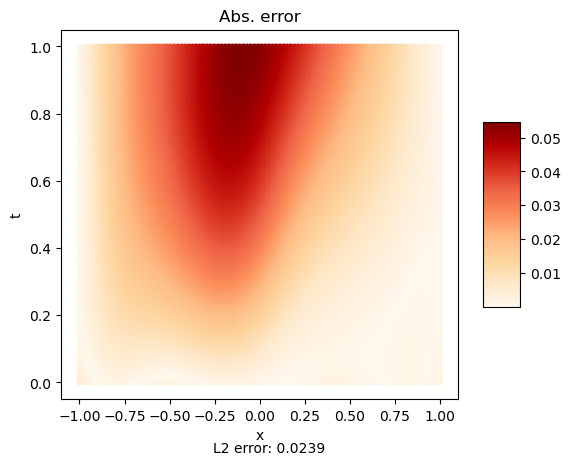

model # of parameters 920
steps  10 accept move
Loss = 0.11933166734203153 Loss new= 0.11082784595295546
Elapsed: 32.3ms
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
steps  10 accept move
Loss = 2.053412442402607e-05 Loss new= 1.82885910202969e-05
Elapsed: 33.0ms
steps  20 accept move
Loss = 1.32102118549072e-05 Loss new= 1.233949629822021e-05
Elapsed: 31.2ms
steps  30 accept move
Loss = 9.7236948326502e-06 Loss new= 9.230023571827024e-06
Elapsed: 31.1ms
steps  40 accept move
Loss = 7.661327800214503e-06 Loss new= 7.344429246015519e-06
Elapsed: 33.3ms
steps  50 accept move
Loss = 6.276143563877926e-06 Loss new= 6.0485076469049435e-06
Elapsed: 36.6ms
steps  60 accept move
Loss = 5.256511022691519e-06 Loss new= 5.0839980420208135e-06
Elapsed: 31.9ms
steps  70 accept move
Loss = 4.4781996303636875e-06 Loss new= 4.345545154387766e-06
Elapsed: 30.6ms
reject move
reject move
reject move
reject move
reject move
reject move
reject 

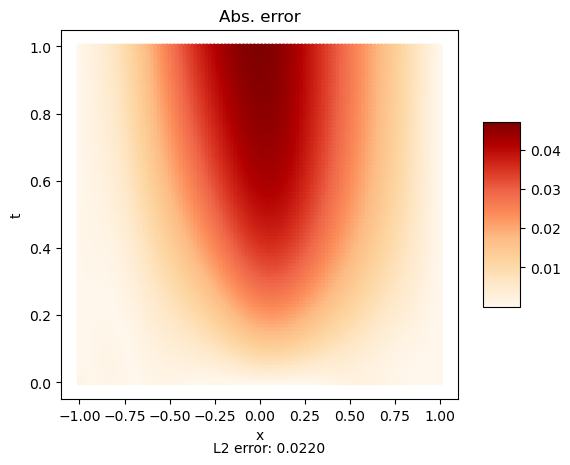

model # of parameters 920
steps  10 accept move
Loss = 0.5298490564725478 Loss new= 0.10983856283282828
Elapsed: 33.8ms
reject move
reject move
reject move
reject move
steps  60 accept move
Loss = 2.6314787159000114e-05 Loss new= 1.8607560399188073e-05
Elapsed: 38.0ms
steps  70 accept move
Loss = 9.261598061718572e-06 Loss new= 8.32313697252733e-06
Elapsed: 30.5ms
steps  80 accept move
Loss = 6.10974232350519e-06 Loss new= 5.7815701699760136e-06
Elapsed: 33.7ms
steps  90 accept move
Loss = 4.900739059715399e-06 Loss new= 4.749034297286986e-06
Elapsed: 31.1ms
steps  100 accept move
Loss = 4.287368380762727e-06 Loss new= 4.196964022540575e-06
Elapsed: 35.0ms
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
steps  10 accept move
Loss = 6.383198078248524e-06 Loss new= 5.366673139382016e-06
Elapsed: 31.8ms
steps  20 accept move
Loss = 2.883110699078897e-06 Loss new= 2.5130214681799795e-06
Elapsed: 36.9ms
steps  30 accept

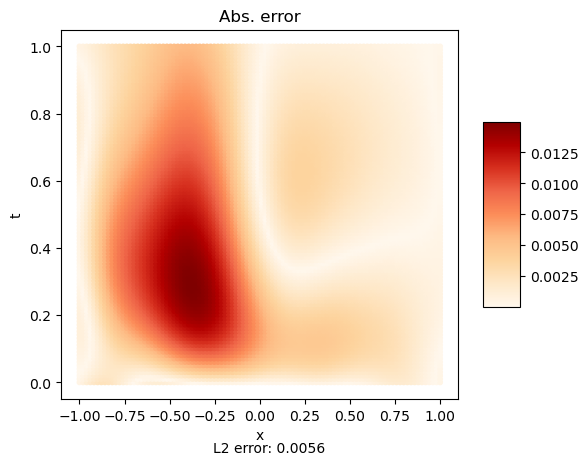

model # of parameters 920
steps  10 accept move
Loss = 0.7994484453154573 Loss new= 0.4344299770328479
Elapsed: 36.7ms
reject move
reject move
reject move
reject move
reject move
steps  70 accept move
Loss = 9.625277248455843e-05 Loss new= 9.475746755703298e-05
Elapsed: 80.2ms
steps  80 accept move
Loss = 2.1094705636222842e-05 Loss new= 1.835895809389133e-05
Elapsed: 37.0ms
steps  90 accept move
Loss = 1.3158187694442322e-05 Loss new= 1.2433736632903605e-05
Elapsed: 43.2ms
steps  100 accept move
Loss = 1.0275306299567055e-05 Loss new= 9.845095072077453e-06
Elapsed: 40.3ms
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
steps  10 accept move
Loss = 1.145186281399417e-06 Loss new= 1.08291234372415e-06
Elapsed: 35.8ms
steps  20 accept move
Loss = 9.084658391581932e-07 Loss new= 8.759590924160234e-07
Elapsed: 34.3ms
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
steps  

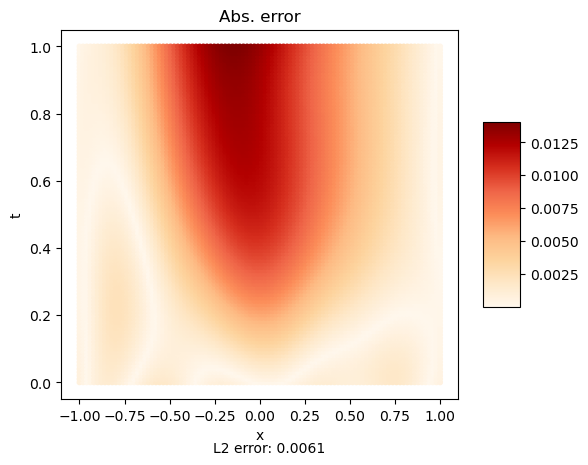

model # of parameters 920
reject move
reject move
reject move
steps  40 accept move
Loss = 0.00011076471573071018 Loss new= 7.458466787749324e-05
Elapsed: 35.8ms
steps  50 accept move
Loss = 2.151117021535508e-05 Loss new= 1.8100901356425197e-05
Elapsed: 33.9ms
steps  60 accept move
Loss = 1.1578881467479195e-05 Loss new= 1.0734465886970542e-05
Elapsed: 36.3ms
steps  70 accept move
Loss = 8.531154250163734e-06 Loss new= 8.150735102166826e-06
Elapsed: 36.0ms
steps  80 accept move
Loss = 6.967280176468345e-06 Loss new= 6.729527810841592e-06
Elapsed: 38.2ms
steps  90 accept move
Loss = 5.925697959959671e-06 Loss new= 5.75364084923942e-06
Elapsed: 36.9ms
steps  100 accept move
Loss = 5.1510213348584704e-06 Loss new= 5.018456114316254e-06
Elapsed: 36.5ms
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
steps  10 accept move
Loss = 5.190191078557815e-06 Loss new= 4.468398583789839e-06
Elapsed: 48.3ms
steps  20 accept move

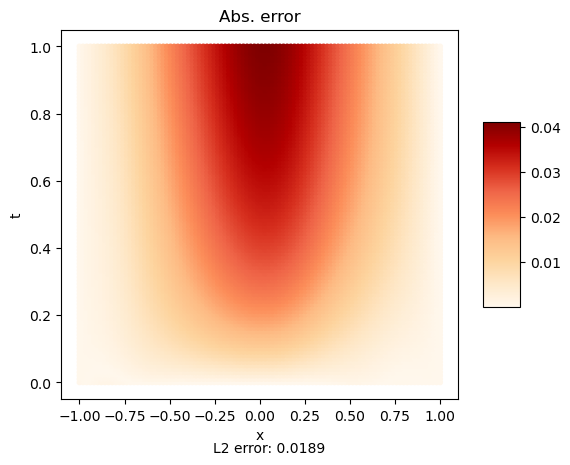

model # of parameters 920
reject move
reject move
steps  30 accept move
Loss = 0.0002898148809741392 Loss new= 9.23894090984586e-05
Elapsed: 40.1ms
steps  40 accept move
Loss = 1.2718234763248483e-05 Loss new= 1.1150400977180843e-05
Elapsed: 45.2ms
steps  50 accept move
Loss = 8.55166952209493e-06 Loss new= 8.179305472079077e-06
Elapsed: 38.3ms
steps  60 accept move
Loss = 7.06457069449675e-06 Loss new= 6.84608227934505e-06
Elapsed: 39.2ms
steps  70 accept move
Loss = 6.114912708293914e-06 Loss new= 5.959118913404612e-06
Elapsed: 34.9ms
steps  80 accept move
Loss = 5.411853610672404e-06 Loss new= 5.2906257648340205e-06
Elapsed: 35.2ms
steps  90 accept move
Loss = 4.854072779125001e-06 Loss new= 4.755375487900608e-06
Elapsed: 42.7ms
steps  100 accept move
Loss = 4.394928721449997e-06 Loss new= 4.312453267018319e-06
Elapsed: 41.7ms
steps  10 accept move
Loss = 1.6357556873819846e-05 Loss new= 1.275147966476214e-05
Elapsed: 38.8ms
steps  20 accept move
Loss = 7.36413261885257e-06 Loss new

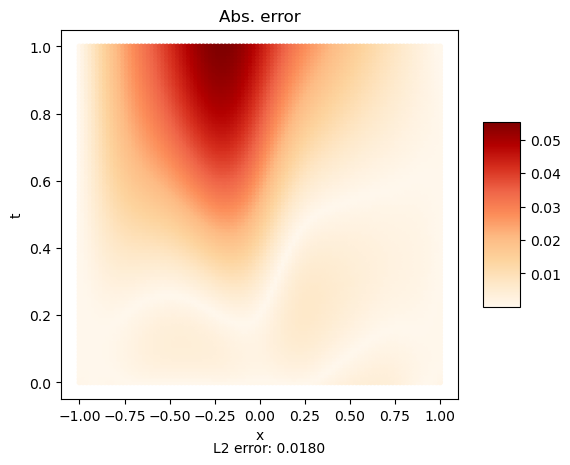

model # of parameters 920
reject move
reject move
reject move
reject move
reject move
steps  60 accept move
Loss = 4.719786320518148e-05 Loss new= 3.182250216372729e-05
Elapsed: 39.3ms
steps  70 accept move
Loss = 1.2245156756409979e-05 Loss new= 1.0883093342446688e-05
Elapsed: 41.7ms
steps  80 accept move
Loss = 8.07110299972282e-06 Loss new= 7.644720257114728e-06
Elapsed: 37.1ms
steps  90 accept move
Loss = 6.401476279475255e-06 Loss new= 6.171367129803243e-06
Elapsed: 38.6ms
steps  100 accept move
Loss = 5.458100526373798e-06 Loss new= 5.319395351336235e-06
Elapsed: 39.7ms
steps  10 accept move
Loss = 1.7080929440521802e-05 Loss new= 1.5700836781436407e-05
Elapsed: 37.4ms
steps  20 accept move
Loss = 1.1875469283982648e-05 Loss new= 1.117854263332381e-05
Elapsed: 36.1ms
steps  30 accept move
Loss = 9.015853179031405e-06 Loss new= 8.59317591304963e-06
Elapsed: 37.4ms
steps  40 accept move
Loss = 7.225416628836961e-06 Loss new= 6.947591430098536e-06
Elapsed: 37.6ms
reject move
reject 

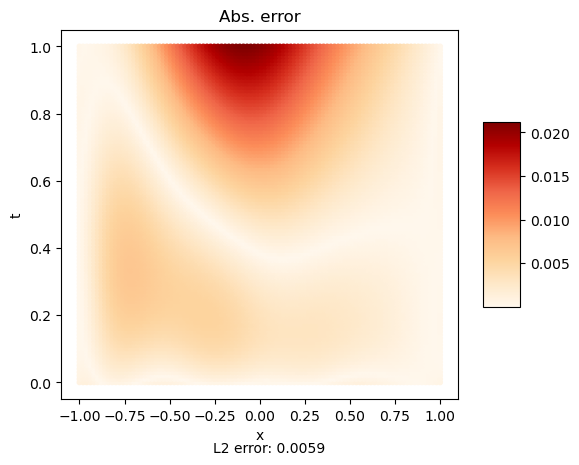

model # of parameters 920
steps  10 accept move
Loss = 0.08832748471299191 Loss new= 0.03244331138572994
Elapsed: 93.2ms
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
steps  50 accept move
Loss = 2.4763073429077998e-08 Loss new= 2.1602144967137015e-08
Elapsed: 41.3ms
steps  60 accept move
Loss = 1.4404906527734088e-08 Loss new= 1.3361719224850743e-08
Elapsed: 39.5ms
steps  70 accept move
Loss = 1.063031088150478e-08 Loss new= 1.0176796026643954e-08
Elapsed: 42.3ms
steps  80 accept move
Loss = 8.847191535637053e-09 Loss new= 8.597383131007842e-09
Elapsed: 52.0ms
steps  90 accept move
Loss = 7.795837012890556e-09 Loss new= 7.632215040803684e-09
Elapsed: 47.5ms
steps  100 accept move
Loss = 7.077568586245215e-09 Loss new= 6.9589023144724735e-09
Elapsed: 38.8ms
re

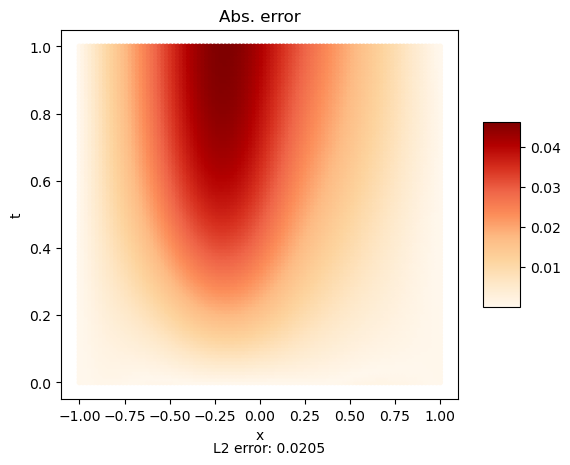

model # of parameters 920
steps  10 accept move
Loss = 0.34941701689863264 Loss new= 0.16285469445684486
Elapsed: 98.4ms
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
reject move
steps  10 accept move
Loss = 2.1167931164597115e-05 Loss new= 1.695961779074543e-05
Elapsed: 44.7ms
steps  20 accept move
Loss = 9.582487514933114e-06 Loss new= 8.65502191809778e-06
Elapsed: 46.4ms
steps  30 accept move
Loss = 6.304305083443183e-06 Loss new= 5.921427244328063e-06
Elapsed: 47.3ms
steps  40 accept move
Loss = 4.817070146289093e-06 Loss new= 4.614912404748005e-06
Elapsed: 47.1ms
steps  50 accept move
Loss = 3.987375410789776e-06 Loss new= 3.864354123384393e-06
Elapsed: 49.2ms
steps  60 accept move
Loss = 3.4630658265467643e-06 Loss new= 3.3805109765465015e-06
Elapsed: 42.1ms
reject move
reject move
reject move
reject move
steps  10 accept move
Loss = 2.718340138317988e-06 Loss new= 2.4416230651262005e-06
Elapsed: 49.1ms
steps  20 accept move
Loss 

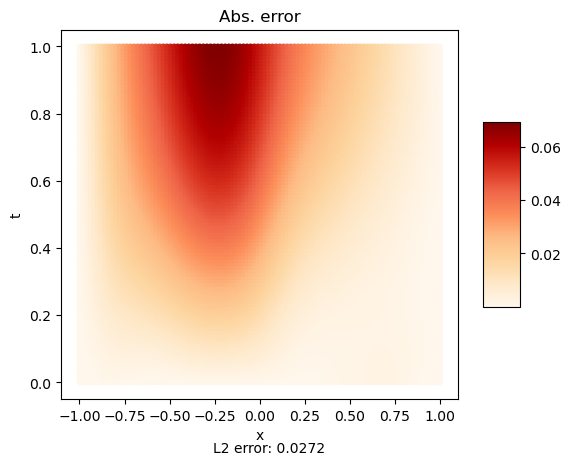

model # of parameters 920
steps  10 accept move
Loss = 0.06985428160923704 Loss new= 0.029413647919530727
Elapsed: 48.6ms
steps  20 accept move
Loss = 2.7660961781379495e-06 Loss new= 8.877025055494155e-07
Elapsed: 48.1ms
steps  30 accept move
Loss = 8.808057941429146e-09 Loss new= 3.4548274445949965e-09
Elapsed: 46.8ms
steps  40 accept move
Loss = 2.814143682794408e-10 Loss new= 2.0735476819893738e-10
Elapsed: 50.6ms
steps  50 accept move
Loss = 1.0374994541924403e-10 Loss new= 9.079240084376401e-11
Elapsed: 51.6ms
steps  60 accept move
Loss = 5.31962310780657e-11 Loss new= 4.6351021644466705e-11
Elapsed: 50.8ms
steps  70 accept move
Loss = 2.6337309535622818e-11 Loss new= 2.2823819836411528e-11
Elapsed: 54.8ms
steps  80 accept move
Loss = 1.2938463637552763e-11 Loss new= 1.126530623125539e-11
Elapsed: 48.8ms
steps  90 accept move
Loss = 6.634510656518599e-12 Loss new= 5.8549880850394176e-12
Elapsed: 46.2ms
steps  100 accept move
Loss = 3.6702412557802935e-12 Loss new= 3.2927794857896

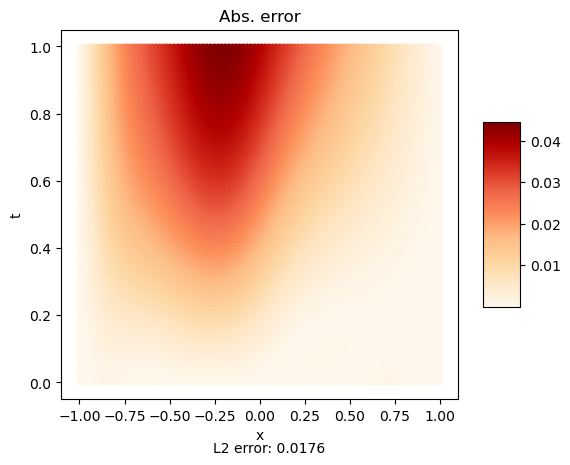

In [15]:
import plot_l2error
torch.cuda.empty_cache() 
avg_time=np.zeros(21)
error=np.zeros(21)
for j in range(21):
    pinns_ran=PINN_S()
    for i in range(10):
        pinns_ran.new_sampling(9+i)
        pinns_ran.LM(20+45*j,100,True)
    avg_time[j]=pinns_ran.avg_time
    error[j]=plot_l2error.plot_model_error(pinns_ran.model, (-1, 1), (0, 1), device='cuda')
x_axis=np.arange(20,920+45,45)

### 图像


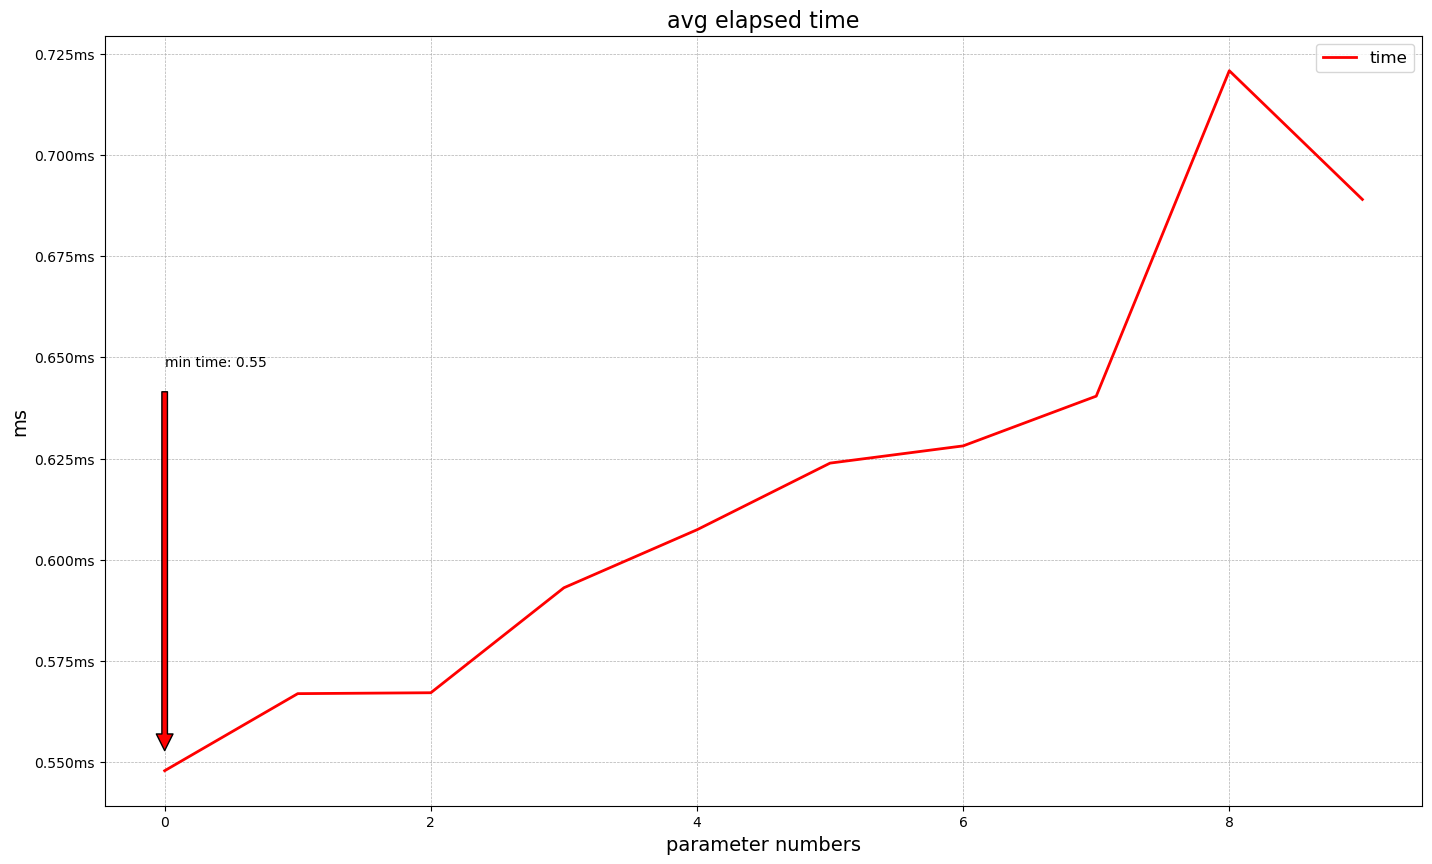

In [25]:
import plot_time
plot_time.plot_time(x_axis,avg_time,'r','-')


error 0.0187325799962605


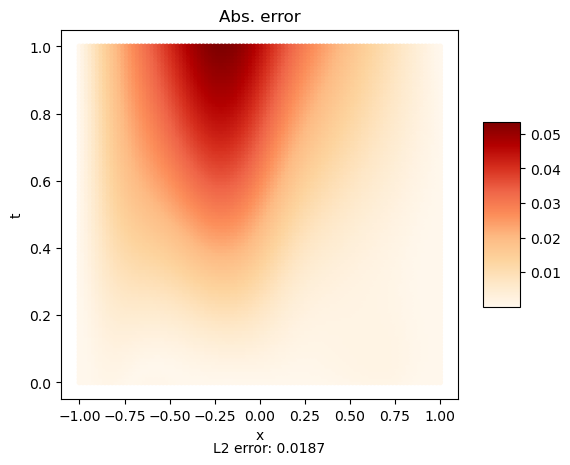

NameError: name 'pinns_ran' is not defined

In [9]:
import plot_l2error
plot_l2error.plot_model_error(pinns_all.model, (-1, 1), (0, 1), device='cuda')
plot_l2error.plot_model_error(pinns_ran.model, (-1, 1), (0, 1), device='cuda')

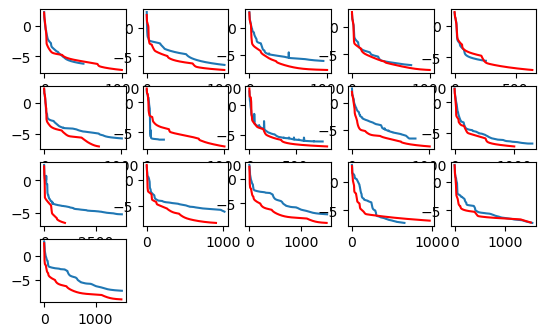

In [29]:
import numpy as np
import matplotlib.pyplot as plt

figure = plt.figure()

# 循环处理每个子图和数据文件

ax = figure.add_subplot(5, 5, i)
    
# 加载并处理第i个数据文件
loss = np.load(f"losspinns_record{i}.npy")
loss = np.log10(loss[loss != 0])
ax.plot(loss)
    
loss_all = np.load(f"losspinnsall_record{i}.npy")
loss_all = np.log10(loss_all[loss_all != 0])
ax.plot(loss_all, 'r')

plt.show()